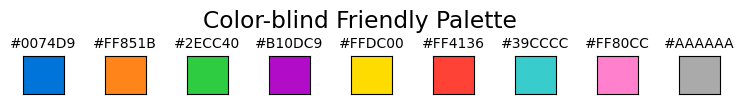

In [2]:
import re
import sys
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [3]:
import re
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

HOME = Path.cwd().parent
workspace = HOME / 'workspaces'

In [4]:
# Helper functions
def format_scores(scores, show_max_min: bool = True):
    mean = np.mean(scores)
    std = np.std(scores)
    if show_max_min:
        min_ = np.min(scores)
        max_ = np.max(scores)
        return f'{mean:.0f}±{std:.0f}'
    else:
        return f'{mean:.0f}±{std:.0f}'

def format_df(res_dict, agg_fn):
    new_res = {
        k: {
            key: agg_fn(val) for key, val in v.items()
        } for k, v in res_dict.items()
    }
    return pd.DataFrame(new_res)

def extract_scores(log_filename):
    with open(log_filename, 'r') as f:
        last_line = f.read().splitlines()[-1]
    scores = {}
    try:
        rmse, mae, mape = re.findall(r'[^:]+: (\d+\.\d+)', last_line)
    except:
        print(log_filename, last_line)
        raise
    scores['RMSE'] = float(rmse) 
    scores['MAE'] = float(mae)
    scores['MAPE'] = float(mape) * 100
    return scores

In [20]:
datasets_to_use = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
sklearn_baseline_names = [
    'dummy',
    'variance_model',
    'discharge_model',
    'full_model',
    'ridge',
    'pcr',
    'plsr',
    'svm',
    'rf'
]
nn_baseline_names = ['mlp', 'cnn', 'lstm']

def collect_results(dataset):
    sklearn_results = [
        sklearn_baselines[dataset][name] for name in sklearn_baseline_names
    ]
    nn_results = [
        nn_baselines[dataset][name] for name in nn_baseline_names
    ]
    our_results = [ours[dataset]['Ours']]
    return sklearn_results + nn_results + our_results

sklearn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/sklearn/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        score = extract_scores(dataset_res / 'log.0')['RMSE']
        # score = min(score, 2000)  # For better visualizability
        sklearn_baselines[dataset][method] = score

nn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/nn_models/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            if score < 2000:  # For better visibility of CNN on MIX-20
                scores.append(score)
        nn_baselines[dataset][method] = scores
ours = defaultdict(dict)

method = 'Ours'
for dataset_res in workspace.glob('ablation/diff_branch/batlinet/*'):
    dataset = dataset_res.name
    try:
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            scores.append(score)
        ours[dataset][method] = scores
    except:
        ours[dataset][method] = 'none'

sklearn_baselines['matr_1']['variance_model'] = 138
sklearn_baselines['matr_2']['variance_model'] = 196
sklearn_baselines['matr_1']['discharge_model'] = 86
sklearn_baselines['matr_2']['discharge_model'] = 173
sklearn_baselines['matr_1']['full_model'] = 100
sklearn_baselines['matr_2']['full_model'] = 214
sklearn_baselines['matr_1']['ridge'] = 125
sklearn_baselines['matr_2']['ridge'] = 188
sklearn_baselines['matr_1']['pcr'] = 100
sklearn_baselines['matr_2']['pcr'] = 176
sklearn_baselines['matr_1']['plsr'] = 97
sklearn_baselines['matr_2']['plsr'] = 193
sklearn_baselines['matr_1']['rf'] = 140
sklearn_baselines['matr_2']['rf'] = 202

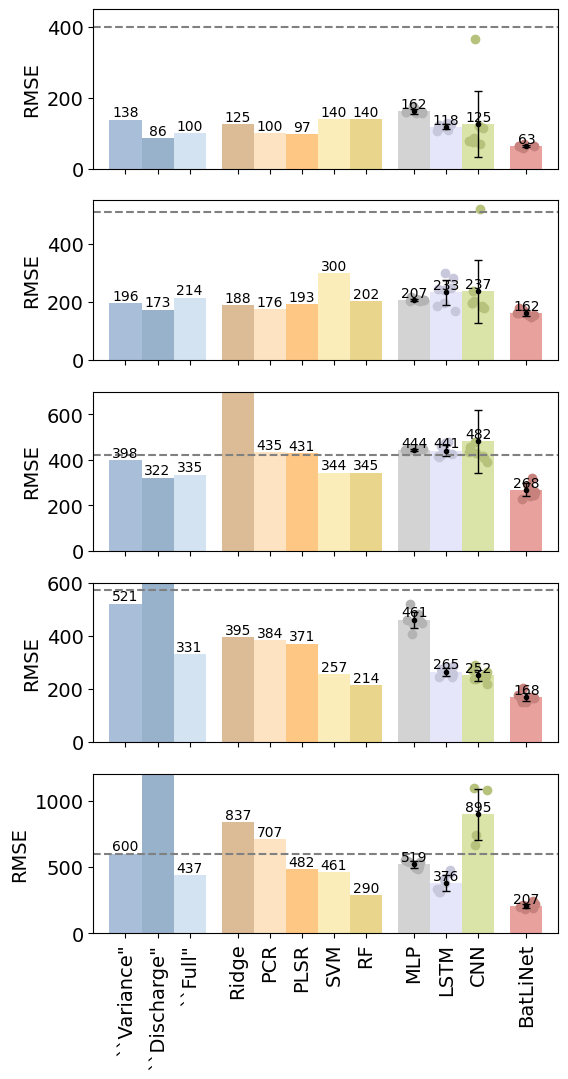

In [21]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr', 'svm', 'rf']:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        ax.annotate(
            f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    ax.annotate(
        f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

ylims = [
    [0, 450],
    [0, 550],
    [0, 700],
    [0, 600],
    [0, 1200]
]

for indx, ax in enumerate(axes):
    ax.set_ylabel('RMSE')
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_xticklabels([
        '``Variance"',
        '``Discharge"',
        '``Full"',
        'Ridge',
        'PCR',
        'PLSR',
        'SVM',
        'RF',
        'MLP',
        'LSTM',
        'CNN',
        'BatLiNet'
    ], rotation=90)
    ax.set_ylim(ylims[indx])
    ax.set_xlim([-1, 13.5])
plt.show()

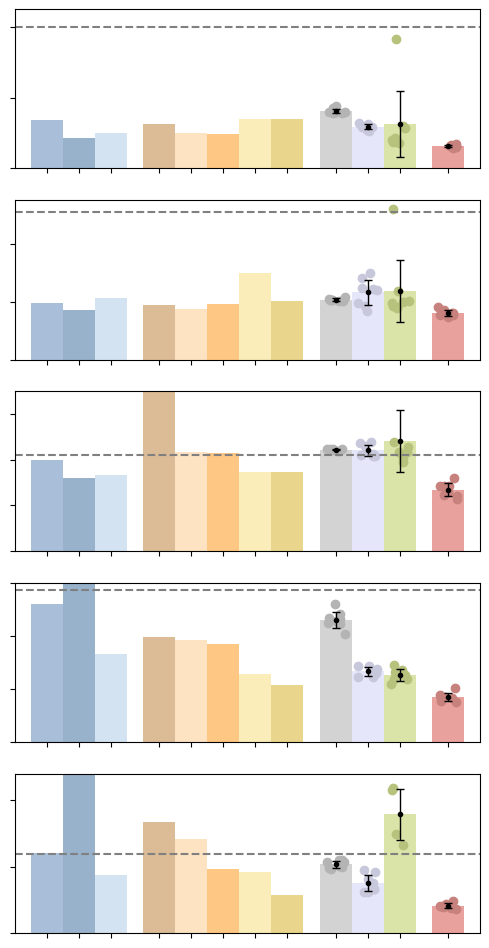

In [47]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr']:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    for method in ['svm', 'rf']:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

ylims = [
    [0, 450],
    [0, 550],
    [0, 700],
    [0, 600],
    [0, 1200]
]

for indx, ax in enumerate(axes):
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylim(ylims[indx])
    ax.set_xlim([-1, 13.5])
fig.savefig(
    HOME / 'data/fig3_rmse_bars.svg',
    bbox_inches='tight',
    pad_inches=0.1,
    transparent=True
)
plt.show()

In [23]:
datasets_to_use = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
sklearn_baseline_names = [
    'dummy',
    'variance_model',
    'discharge_model',
    'full_model',
    'ridge',
    'pcr',
    'plsr',
    'svm',
    'rf'
]
nn_baseline_names = ['mlp', 'cnn', 'lstm']

def collect_results(dataset):
    sklearn_results = [
        sklearn_baselines[dataset][name] for name in sklearn_baseline_names
    ]
    nn_results = [
        nn_baselines[dataset][name] for name in nn_baseline_names
    ]
    our_results = [ours[dataset]['Ours']]
    return sklearn_results + nn_results + our_results

sklearn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/sklearn/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        score = extract_scores(dataset_res / 'log.0')['MAPE']
        score = min(score, 120)  # For better visualizability
        sklearn_baselines[dataset][method] = score

nn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/nn_models/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['MAPE']
            if score < 120:  # For better visualizability
                scores.append(score)
        nn_baselines[dataset][method] = scores
ours = defaultdict(dict)

method = 'Ours'
for dataset_res in workspace.glob('ablation/diff_branch/batlinet/*'):
    dataset = dataset_res.name
    try:
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['MAPE']
            if score < 120:  # For better visualizability
                scores.append(score)
        ours[dataset][method] = scores
    except:
        ours[dataset][method] = 'none'

sklearn_baselines['matr_1']['variance_model'] = 15.
sklearn_baselines['matr_2']['variance_model'] = 12.
sklearn_baselines['matr_1']['discharge_model'] = 8.
sklearn_baselines['matr_2']['discharge_model'] = 11.
sklearn_baselines['matr_1']['full_model'] = 11.
sklearn_baselines['matr_2']['full_model'] = 12.
sklearn_baselines['matr_1']['ridge'] = 13.
sklearn_baselines['matr_2']['ridge'] = 11.
sklearn_baselines['matr_1']['pcr'] = 11.
sklearn_baselines['matr_2']['pcr'] = 11.
sklearn_baselines['matr_1']['plsr'] = 10.
sklearn_baselines['matr_2']['plsr'] = 11.
sklearn_baselines['matr_1']['rf'] = 15.
sklearn_baselines['matr_2']['rf'] = 11.


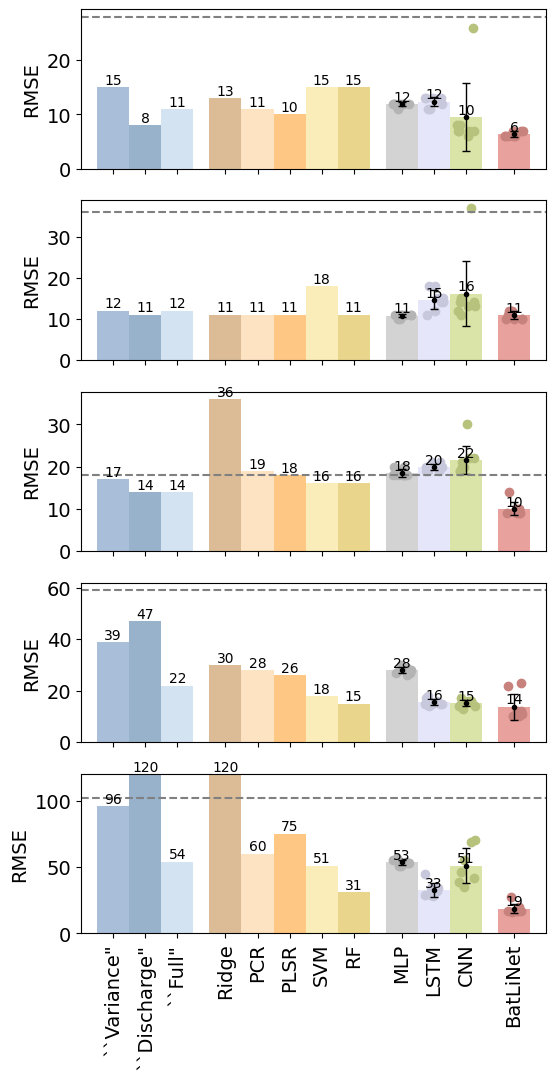

In [24]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr', 'svm', 'rf']:
        s = sklearn_baselines[dataset][method]
        ax.bar(x=x, height=s, width=1, color=colors[indx])
        ax.annotate(f'{s:.0f}', (x, s), ha='center', va='bottom', fontsize=10)
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        ax.annotate(
            f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    ax.annotate(
        f'{mean:.0f}', (x, mean), ha='center', va='bottom', fontsize=10
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

for indx, ax in enumerate(axes):
    ax.set_ylabel('RMSE')
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_xticklabels([
        '``Variance"',
        '``Discharge"',
        '``Full"',
        'Ridge',
        'PCR',
        'PLSR',
        'SVM',
        'RF',
        'MLP',
        'LSTM',
        'CNN',
        'BatLiNet'
    ], rotation=90)
    ylim = ax.get_ylim()
    ax.set_ylim([ylim[0], min(ylim[1], 120)])
    ax.set_xlim([-1, 13.5])
plt.show()


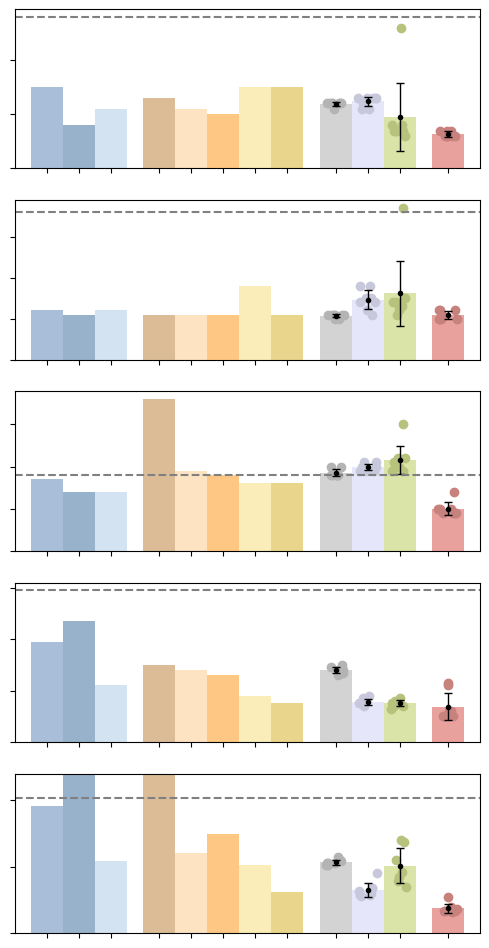

In [44]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

fig, axes = plt.subplots(5, 1, figsize=(6, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Blues
     '#DBBC97', '#FEE3C3', '#FFC784', '#FAEDB9', 
    '#E9D68C', # Yellows
    '#D3D3D3', '#E6E6FA', '#DAE3A8',  # Low saturation colors
    # Red
    '#E8A19D'
]
color_to_dotcolor = {
    '#D3D3D3': '#B4B4B4',
    '#E6E6FA': '#C8C8DC',
    '#DAE3A8': '#B7C27D',
    '#E8A19D': '#C8827D'
}

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)


for ax, dataset in zip(axes, datasets_to_use):

    x, indx = 0, 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    x += 0.5

    for method in ['ridge', 'pcr', 'plsr']:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    for method in ['svm', 'rf']:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[indx]
        )
        x += 1
        indx += 1
    x += 0.5

    for method in ['mlp', 'lstm', 'cnn']:
        mean = np.mean(nn_baselines[dataset][method])
        std = np.std(nn_baselines[dataset][method])
        ax.bar(
            x=x,
            height=mean,
            width=1,
            color=colors[indx]
        )
        draw_points_around(
            ax,
            x,
            nn_baselines[dataset][method],
            width=1,
            color=color_to_dotcolor[colors[indx]]
        )
        ax.errorbar(
            x, mean, std,
            fmt='o',
            ecolor='black',
            color='black',
            elinewidth=1,
            capsize=3,
            markersize=3
        )
        x += 1
        indx += 1
    x += 0.5

    method = 'Ours'
    mean = np.mean(ours[dataset][method])
    std = np.std(ours[dataset][method])
    ax.bar(
        x=x,
        height=mean,
        width=1,
        color=colors[indx]
    )
    draw_points_around(
        ax,
        x,
        ours[dataset][method],
        width=1,
        color=color_to_dotcolor[colors[indx]]
    )
    ax.errorbar(
        x, mean, std,
        fmt='o',
        ecolor='black',
        color='black',
        elinewidth=1,
        capsize=3,
        markersize=3
    )

    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=-1,
        xmax=14,
        colors='gray',
        linestyle='dashed'
    )

for indx, ax in enumerate(axes):
    ax.set_xticks([
        0, 1, 2, 3.5, 4.5, 5.5, 6.5, 7.5, 9, 10, 11, 12.5
    ])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # ax.set_ylim(ylims[indx])
    ylim = ax.get_ylim()
    ax.set_ylim([ylim[0], min(ylim[1], 120)])
    ax.set_xlim([-1, 13.5])
fig.savefig(
    HOME / 'data/fig3_mape_bars.svg',
    bbox_inches='tight',
    pad_inches=0.1,
    transparent=True
)
plt.show()
